In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Simulate spatial transcriptomic data

## Introduction

In this example, we show how to use scDesign3Py to simulate the single-cell spatial data.

## Import packages and Read in data

### import pacakges

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scDesign3Py

The R project used is located at /home/ld/anaconda3/envs/pyscdesign/lib/R


### Read in the reference data

The raw data is from the [Seurat](https://satijalab.org/seurat/articles/spatial_vignette.html), which is a dataset generated with the Visium technology from 10x Genomics. We pre-select the top spatial variable genes. To save time, we only use the top 10 genes.

In [3]:
data = ad.read_h5ad("data/VISIUM.h5ad")
data = data[:,0:10]
data

View of AnnData object with n_obs × n_vars = 2696 × 10
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'spatial1', 'spatial2', 'cell_type'
    var: 'name'

## Simulation

Then, we can use this spatial dataset to generate new data by setting the parameter mu_formula as a smooth terms for the spatial coordinates.

In [4]:
test = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")
test.set_r_random_seed(123)
simu_res = test.scdesign3(
    anndata = data,
    default_assay_name = "counts",
    celltype = "cell_type",
    spatial = ["spatial1", "spatial2"],
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k= 400)",
    sigma_formula = "1",
    family_use = "nb",
    usebam = False,
    corr_formula = "1",
    copula = "gaussian",
  )

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 02:43


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:08


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 00:08


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:00


R[write to console]: New Data Generating End



Then we can construct new data using the simulated count matrix.

In [5]:
simu_data = ad.AnnData(X=simu_res["new_count"], obs=simu_res["new_covariate"])
simu_data.layers["log_transformed"] = np.log1p(simu_data.X)

## Visualization

We plot a selected gene as an example showing the gene expression and the spatial locations.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

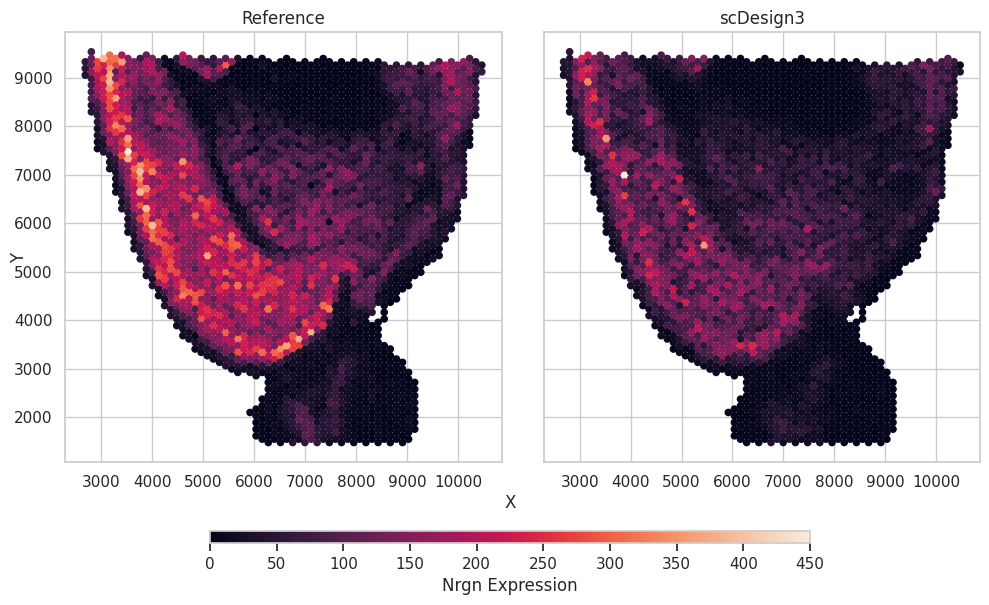

In [7]:
gene_name = "Nrgn"

df = pd.concat([data.obs[["spatial1","spatial2"]],simu_data.obs[["spatial1","spatial2"]]],axis=0)
df["Expression"] = np.concatenate([data[:,gene_name].X.toarray().flatten(),simu_data[:,gene_name].X.toarray().flatten()])
df["Method"] = ["Reference"]*data.n_obs + ["scDesign3"]*simu_data.n_obs


# plot
sns.set(style="whitegrid")
methods = df.groupby("Method")
fig, axes = plt.subplots(1, len(methods), figsize=(len(methods) * 5, 1 * 5), sharey=True, sharex=True)
fig.tight_layout()

for i, (method, exp) in enumerate(methods):
    ax = axes[i]

    scatter = ax.scatter(
        exp["spatial1"],
        exp["spatial2"],
        c=exp["Expression"],
        alpha=1,
        s=20,
    )
    ax.set_title(method)

fig.text(0.5, 0, "X", ha="center")
fig.text(0, 0.5, "Y", va="center", rotation="vertical")
position = fig.add_axes([0.2, -0.07, 0.60, 0.025])
fig.colorbar(scatter,                cax=position,
                orientation="horizontal",
                label=f"{gene_name} Expression",)
fig.show()